# Lab 3

## Imports

In [1]:
from typing import Any

import torch
from torch.autograd import Function
from torch import Tensor

import matplotlib.pyplot as plt
from  matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

## Exercise 1 (5P)
This exercise is about gradient descent. We will use the function
$f(x_1, x_2)=(x_1-6)^2+x_2^2-x_1x_2$ as a running example:

 1. Use pen and paper to do three iterations of gradient descent: (2P)
     - Find the gradient of $f$;
     - Start from the point $x_1=x_2=6$ and use a step size of $1/2$ for the first step,
    $1/3$ for the second step and $1/4$ for the third step;
     - What will happen if you keep going?
 2. Write a function that performs gradient descent:    (3P)
     - For simplicity, we use a constant learning rate.
     - Can you find a way to prematurely stop the optimization when you are close to the
    optimum?

In [2]:
# Note: Defining a custom autograd function is not a necessity for this small task,
# but it is a good place to showcase some capabilities of PyTorch.

class MyFunction(Function):
    @staticmethod
    def forward(ctx: Any, x: Tensor) -> Tensor:
        # The "ctx" object serves to stash information for the backward pass
        ctx.save_for_backward(x)
        x1, x2 = x[0], x[1]
        func_value = (x1 - 6)**2 + x2**2 - x1*x2
        return func_value

    @staticmethod
    def backward(ctx: Any, grad_output: Tensor):
        # The "grad_output" parameter is the backpropagated gradient from subsequent
        # operations w.r.t. to the output of this function.
        x = ctx.saved_tensors[0]

        x1, x2 = x[0], x[1]
        grad_x = torch.tensor([
            2*(x1 - 6) - x2,
            2 * x2 - x1
        ])
        return grad_output * grad_x

In [3]:

func = MyFunction()
# The "required_grad" argument needs to be True.
# Otherwise no gradients will be computed.
x = torch.tensor([6., 6.], requires_grad=True)


# Custom functions are applied over the "apply" method.
y = func.apply(x)
print('Function output: {}'.format(y))

# Gradients for every operation in this chain are computed
# by calling the "backward" method on the output tensor.
y.backward()

# The x tensor now has a grad attribute with the gradients.
print('Gradients: {}'.format(x.grad))

# Note: No usage of auto differentiation was done in this example.

Function output: 0.0
Gradients: tensor([-6.,  6.])


C:\Users\Ahmed\AppData\Local\Temp\ipykernel_7908\3778259353.py:1: DeprecationWarning: <class '__main__.MyFunction'> should not be instantiated. Methods on autograd functions are all static, so you should invoke them on the class itself. Instantiating an autograd function will raise an error in a future version of PyTorch.
  func = MyFunction()


Does it match what you computed?

In the next step we define a small gradient descent optimizer.

In [4]:

class GradientDescentOptimizer:
    def __init__(self,
                 func: Function,
                 max_steps: int,
                 alpha: float):
        """
        Init an Optimizer for performing GD.

        :param func: Function to apply.
        :param max_steps: Maximum number of GD steps.
        :param alpha: Learning Rate.
        """
        self.func = func
        self.max_steps = max_steps
        self.alpha = alpha

    def __call__(self, x: Tensor) -> Tensor:
        """
        Apply GD on a tensor.

        :param x: Input tensor.
        """
        # Usually you would apply the gradients inplace on the input tensor,
        # but for the sake of the example we keep the input tensor consistent and
        # work on a copy.
        x_cp = x.detach().clone()
        x_cp.requires_grad = True

# TODO use a for loop to do gradient descent.
# HINT When applying gradients you will need an "torch.no_grad()" context
# manager. To modify the content of the tensor you will need its ".data"
# attribute. Don't forget to erase the gradients after each iteration or
# or they will accumulate.

        for _ in range(self.max_steps):
            y = self.func.apply(x_cp)
            y.backward()
            with torch.no_grad():
                x_cp -= self.alpha * x_cp.grad

            x_cp.grad.zero_()

        return x_cp

In [5]:
x = torch.tensor([6., 6.], requires_grad=True)
gd_optimizer = GradientDescentOptimizer(func=MyFunction(), max_steps=10, alpha=0.1)
x_new = gd_optimizer(x)
print(x_new)

tensor([7.9435, 4.0565], requires_grad=True)


C:\Users\Ahmed\AppData\Local\Temp\ipykernel_7908\18501786.py:2: DeprecationWarning: <class '__main__.MyFunction'> should not be instantiated. Methods on autograd functions are all static, so you should invoke them on the class itself. Instantiating an autograd function will raise an error in a future version of PyTorch.
  gd_optimizer = GradientDescentOptimizer(func=MyFunction(), max_steps=10, alpha=0.1)


## Exercise 2 (5P)

Now that we know how to do gradient descent and how to compute the derivatives of the
weights of a simple network, we can try to do these steps together and train our first
neural network! We will use the small dataset with five points we studied in the first
lab.

First, let's define the dataset:

In [6]:
x = torch.tensor([
    [0, 0],
    [1, 0],
    [0, -1],
    [-1, 0],
    [0, 1]
], dtype=torch.float)
y = torch.tensor([1, 0, 0, 0, 0])

Next, a function to compute the output of the network: (1P)

In [7]:

def sigmoid(x: Tensor) -> Tensor:
    # TODO compute the sigmoid on x and return.
    return 1 / (1 + torch.exp(-x))

def predict(x: Tensor, b1: float, b2: float,
            w11: float, w12: float, w21: float, w22: float,
            c: float, u1: float, u2:float) -> Tensor:
# TODO compute and return the output of the network.
    z1 = w11 * x[:,0] + w12 * x[:,1] + b1
    z2 = w21 * x[:,0] + w22 * x[:,1] + b2
    a1 = torch.tanh(z1)
    a2 = torch.tanh(z2)
    fin = u1 * a1 + u2 * a2 + c
    fout = sigmoid(fin)
    return fout.float()
# This should return the predictions for the five points in the datasets
# We can unpack the param vector for the positional params of the function so that we don't
# need to enter every single entry.
params = torch.randn(9)
predictions = predict(x, *params)
print("predictions:", predictions)

predictions: tensor([0.1440, 0.3474, 0.1206, 0.1071, 0.1930])


Since gradient descent is done on the loss function, we need a function to compute it:  (1P)

In [ ]:

def get_loss(target: Tensor, pred: Tensor) -> Tensor:
# TODO return the average loss.
    # We use cross-entropy loss for binary classification Ref:(02_01_slides: 1)
    loss = -(target * pred.log() + (1 - target) * (1 - pred).log())
    return loss

loss = get_loss(y, predictions)
print(loss)

tensor([1.9382, 0.4268, 0.1285, 0.1133, 0.2144])


Now, we need to compute the gradient of each parameter: (3P)

In [ ]:

def get_gradients(x: Tensor, target: Tensor,
            b1: float, b2: float,
            w11: float, w12: float, w21: float, w22: float,
            c: float, u1: float, u2:float) -> Tensor:
    # First, we perform the forward pass.
    z1in = b1 + x[:, 0] * w11 + x[:, 1] * w21
    z1out = torch.tanh(z1in)

    z2in = b2 + x[:, 0] * w12 + x[:, 1] * w22
    z2out = torch.tanh(z2in)

    fin = c + u1 * z1out + u2 * z2out
    fout = sigmoid(fin)

# TODO compute all the partial derivatives.
    dL_dfout = fout - target.float()
    dL_dfin = dL_dfout * sigmoid(fin) * (1 - sigmoid(fin))

    dL_dc = dL_dfin.mean()
    dL_du1 = (dL_dfin * z1out).mean()
    dL_du2 = (dL_dfin * z2out).mean()


    dz1 = dL_dfin * u1 * (1 - z1out**2)
    dz2 = dL_dfin * u2 * (1 - z2out**2)

    dL_db1 = dz1.mean()
    dL_db2 = dz2.mean()

    dL_dw11 = (dz1 * x[:,0]).mean()
    dL_dw21 = (dz1 * x[:,1]).mean()
    dL_dw12 = (dz2 * x[:,0]).mean()
    dL_dw22 = (dz2 * x[:,1]).mean()
    
    # Return the derivatives in the same order as the parameters vector
    return torch.stack([
        dL_db1, dL_db2, dL_dw11, dL_dw12, dL_dw21, dL_dw22, dL_dc, dL_du1, dL_du2  
    ])

print(get_gradients(x, y, *params))

tensor([-0.0004, -0.0002, -0.0047, -0.0003,  0.0048,  0.0003,  0.0022, -0.0144,
        -0.0022])


Finite differences are a useful way to check that the gradients are computed correctly:

In [10]:

# First, compute the analytical gradient of the parameters.
gradient = get_gradients(x, y, *params)
print("gradient:", gradient)
eps = 1e-9
for i in range(9):
    # Compute loss when subtracting eps to parameter i.
    neg_params = params.clone()
    neg_params[i] = neg_params[i] - eps
    neg_value = get_loss(y, predict(x, *neg_params))

    # Compute loss when adding eps to parameter i.
    pos_params = params.clone()
    pos_params[i] = pos_params[i] + eps
    pos_value = get_loss(y, predict(x, *pos_params))

    # Compute the "empirical" gradient of parameter i
    fdiff_gradient = torch.mean((pos_value - neg_value) / (2 * eps))

    # Error if difference is too large
    if torch.abs(gradient[i] - fdiff_gradient) < 1e-5:
        raise ValueError('Gradients are probably wrong!')

print("Gradients are correct!")

gradient: tensor([-0.0004, -0.0002, -0.0047, -0.0003,  0.0048,  0.0003,  0.0022, -0.0144,
        -0.0022])
Gradients are correct!


We can finally train our network. Since the network is so small compared to the dataset,
 the training procedure is very sensitive to the way the weights are initialized and
 the step size used in gradient descent.

Try to play around with the learning rate and the random initialization of the weights
and find reliable values that make training successful in most cases.

In [12]:

min_loss = float('inf')
alpha = 0.3
steps = 100
best_params = None

for i in range(10):
    params = torch.randn(9)

    # Do GD
    for _ in range(steps):
        gradients = get_gradients(x, y, *params)
        params -= alpha * gradients

    final_loss = get_loss(y, predict(x, *params))
    mean_loss = float(torch.mean(final_loss))
    print('RUN {} \t LOSS {:.4f}'.format(i + 1, mean_loss))

    if mean_loss < min_loss:
        best_params = params.clone()
        min_loss = mean_loss

RUN 1 	 LOSS 0.9074
RUN 2 	 LOSS 0.5055
RUN 3 	 LOSS 0.5301
RUN 4 	 LOSS 0.5314
RUN 5 	 LOSS 0.5770
RUN 6 	 LOSS 0.5084
RUN 7 	 LOSS 0.6705
RUN 8 	 LOSS 0.5368
RUN 9 	 LOSS 0.6200
RUN 10 	 LOSS 0.5863


We can use the function in the previous lab to visualize the decision boundary of
the best network:

In [13]:

def plot_decision_boundary(
        x: Tensor, y: Tensor, grid_x: Tensor, grid_y, pred: Tensor) -> None:
    """Plot the estimated decision boundary for a 2D grid with predictions."""
    plt.contourf(grid_x, grid_y, pred.view(grid_x.shape))
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap='jet')
    plt.show()

In [14]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # allow duplicate OpenMP DLL
import torch


c:\Users\Ahmed\anaconda3\Lib\site-packages\torch\functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4319.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


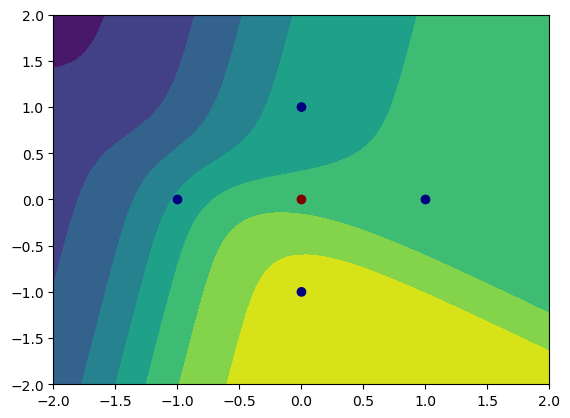

In [15]:

grid_range = torch.linspace(-2, 2, 50)
grid_x, grid_y = torch.meshgrid(grid_range, grid_range)
grid_data = torch.stack([grid_x.flatten(), grid_y.flatten()]).T
pred = predict(grid_data, *best_params)

plot_decision_boundary(x, y, grid_x, grid_y, pred)



Also try to visualize the decision boundary of network with random parameters:

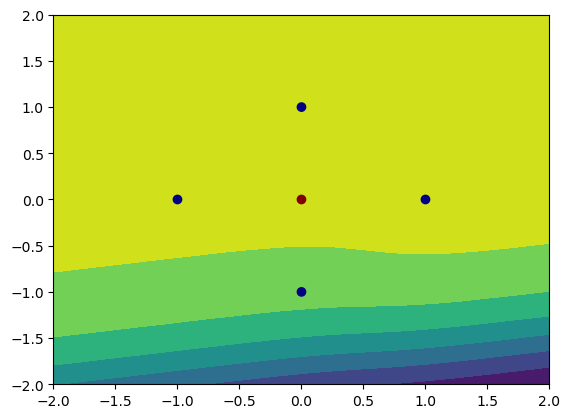

In [16]:
pred = predict(grid_data, *torch.randn(9))
plot_decision_boundary(x, y, grid_x, grid_y, pred)